In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
   import pickle
   with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
   return dict
dict_1 = unpickle('cifar-10-batches-py/data_batch_1')
dict_2 = unpickle('cifar-10-batches-py/data_batch_2')
dict_3 = unpickle('cifar-10-batches-py/data_batch_3')
dict_4 = unpickle('cifar-10-batches-py/data_batch_4')
dict_5 = unpickle('cifar-10-batches-py/data_batch_5')


print(dict_1.keys())
print(len(dict_2[b'labels']))

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000


In [3]:
fil = unpickle('cifar-10-batches-py/batches.meta')
label_name = fil[b'label_names']
label_name

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [4]:
dict_6 = unpickle('cifar-10-batches-py/test_batch')
img_test = dict_6[b'data']
img_test = img_test.reshape(img_test.shape[0],3,32,32)
val_test = dict_6[b'labels']
val_test = np.array(val_test)

In [5]:
img1 = dict_1[b'data']
img2 = dict_2[b'data']
img3 = dict_3[b'data']
img4 = dict_4[b'data']
img5 = dict_5[b'data']
img = np.concatenate((img1,img2,img3,img4,img5))
img = img.reshape(img.shape[0],3,32,32)
img.shape

(50000, 3, 32, 32)

In [6]:
val1 = dict_1[b'labels']
val2 = dict_2[b'labels']
val3 = dict_3[b'labels']
val4 = dict_4[b'labels']
val5 = dict_5[b'labels']
val = val1 +val2+val3+val4+val5
val = np.array(val)


truck


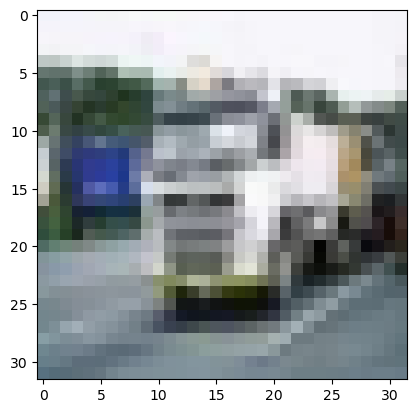

In [7]:
def show_image(x):
   x = x.transpose(1,2,0)
   plt.imshow(x)
print(label_name[val[1000]].decode("utf-8"))
show_image(img[1000])


In [8]:
img = img/255
img_test = img_test/255
img.shape

(50000, 3, 32, 32)

Neural Network


In [9]:
import torch
import torch.nn as nn
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, 3000)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(3000, 1000)
        self.final = nn.Linear(1000, num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.final(out)
        
        return out
        

In [10]:
X_train = torch.from_numpy(img)
y_train = torch.from_numpy(val)
X_test = torch.from_numpy(img_test)
y_test = torch.from_numpy(val_test)

In [11]:
device = 'cuda'
input_size = 3072
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001
y_train[0]

tensor(6, dtype=torch.int32)

In [12]:
model = NeuralNet(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total = len(X_train)
for epoch in range(num_epochs):
   running_loss = 0.0
   cnt = 0
   for start in range(0,n_total,batch_size):
      X_batch = X_train[start:start+batch_size].flatten(start_dim=1).float().to(device)
      y_batch = y_train[start:start+batch_size].to(torch.int64).to(device)
         
      output = model(X_batch)
      loss = criterion(output, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      cnt+=1
   
   print(f'epoch {epoch+1}/{num_epochs}, loss = {running_loss/cnt:.4f}')
   running_loss=0
   cnt=0

epoch 1/10, loss = 2.2479
epoch 2/10, loss = 2.1318
epoch 3/10, loss = 2.0347
epoch 4/10, loss = 1.9720
epoch 5/10, loss = 1.9283
epoch 6/10, loss = 1.8958
epoch 7/10, loss = 1.8701
epoch 8/10, loss = 1.8479
epoch 9/10, loss = 1.8276
epoch 10/10, loss = 1.8083


In [13]:
with torch.no_grad():
   n_correct = 0
   n_samples = len(y_test)
   y_test = y_test.to(device)
   for i in range(1):
      X_t = X_test.flatten(start_dim=1).float().to(device)
      output = model(X_t)
      for i in range(output.shape[0]):
         if(torch.argmax(output[i])==y_test[i]): 
            n_correct += 1
   acc = 100*(n_correct / n_samples)
   print(f'accuracy = {acc}')

accuracy = 36.64


CNN

In [14]:
cnn_lr = 0.001
cnn_epo = 10
cnn_batsiz = 32
img.shape

(50000, 3, 32, 32)

In [15]:
class ConvNet(nn.Module):
   def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(3,32,3)
      self.pool = nn.MaxPool2d(2,2)
      self.conv2 = nn.Conv2d(32, 64, 4)
      self.fc1 = nn.Linear(64 * 6 * 6, 1000)
      self.fc2 = nn.Linear(1000, 64)
      self.fc3 = nn.Linear(64, 10)

   def forward(self, x):
      # -> n, 3, 32, 32
      x = self.pool(nn.functional.relu(self.conv1(x)))  # -> n, 32, 15, 15
      x = self.pool(nn.functional.relu(self.conv2(x)))  # -> n, 64, 6, 6
      x = x.view(-1, 64 * 6 * 6)            # -> n, 2304
      x = nn.functional.relu(self.fc1(x))               # -> n, 120
      x = nn.functional.relu(self.fc2(x))               # -> n, 84
      x = (self.fc3(x))                       # -> n, 10
      return x

In [16]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.adam(model.parameters(), lr=cnn_lr)

for e in range(cnn_epo):
   running_loss = 0.0
   cnt=0
   for start in range(0,n_total,cnn_batsiz):
      X_batch = X_train[start:start+cnn_batsiz].float().to(device)
      y_batch = y_train[start:start+cnn_batsiz].to(torch.int64).to(device)
         
      output = model(X_batch)
      loss = criterion(output, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      cnt+=1
   print(f'Epoch [{e+1}/{cnn_epo}, Loss : {running_loss/cnt:.4f}]')
   cnt=0
print("DONE")

Epoch [1/10, Loss : 2.2666]
Epoch [2/10, Loss : 1.9906]
Epoch [3/10, Loss : 1.7354]
Epoch [4/10, Loss : 1.5451]
Epoch [5/10, Loss : 1.4352]
Epoch [6/10, Loss : 1.3514]
Epoch [7/10, Loss : 1.2752]
Epoch [8/10, Loss : 1.2044]
Epoch [9/10, Loss : 1.1374]
Epoch [10/10, Loss : 1.0738]
DONE


In [17]:
with torch.no_grad():
   n_correct = 0
   n_samples = len(y_test)
   n_class_correct = [0 for i in range(10)]
   n_class_samples = [0 for i in range(10)]
   
   for i in range(1):
      X_t = X_test.float().to(device)
      output = model(X_t)
      for i in range(output.shape[0]):
         if(torch.argmax(output[i])==y_test[i]): 
            n_correct += 1
            n_class_correct[y_test[i]] +=1
         n_class_samples[y_test[i]] +=1
   acc = 100.0 * (n_correct / n_samples)
   print(f'Accuracy of the network: {acc:.4f} %')

   for i in range(10):
      acc = 100.0 * (n_class_correct[i] / n_class_samples[i])
      print(f'Accuracy of {label_name[i].decode("utf-8")}: {acc:.4f} %')

Accuracy of the network: 61.0000 %
Accuracy of airplane: 71.0000 %
Accuracy of automobile: 82.2000 %
Accuracy of bird: 40.1000 %
Accuracy of cat: 39.4000 %
Accuracy of deer: 57.4000 %
Accuracy of dog: 40.6000 %
Accuracy of frog: 71.6000 %
Accuracy of horse: 79.4000 %
Accuracy of ship: 68.0000 %
Accuracy of truck: 60.3000 %
